# Соревнование на Kaggle
**Ссылка**: https://www.kaggle.com/c/quickdraw-doodle-recognition/overview

Score: 0.8

# Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.


In [0]:
import tensorflow as tf
import keras
from keras import backend as K

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization

# Download data from Kaggle

In [14]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

    100% |████████████████████████████████| 61kB 2.7MB/s 
    100% |████████████████████████████████| 235kB 5.6MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [9]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME=adtsvetkova KAGGLE_KEY=711dab66e0f54e09951120830972f100 kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

train_simplified.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [0]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

# Images generator

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw

IMG_SIZE = 64

# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256, 256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    return np.array(image, dtype=np.uint8)

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

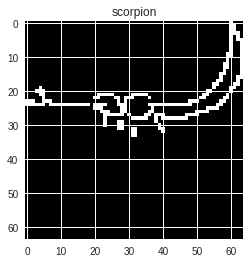

In [0]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

#Эксперименты с архитектурой CNN


# Эксперимент №1

Простая CNN c повторяющимися сверточными слоями и батч нормализацией

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [141]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
def make_model():
   
    model = Sequential()
    

    model.add(Conv2D(32, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(Conv2D(32, (3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

    model.add(Flatten())

    model.add(Dense(256, activation='elu'))

    model.add(Dense(64, activation='elu'))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [144]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 128
STEPS_PER_EPOCH = 500
EPOCHS = 100

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

In [0]:
CNN_batchnorm = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/100
500/500 [==============================] - 62s 124ms/step - loss: 5.0476 - categorical_accuracy: 0.0550 - top_3_accuracy: 0.1199
Model saved in model_0
Epoch 2/100
500/500 [==============================] - 61s 122ms/step - loss: 3.6879 - categorical_accuracy: 0.2133 - top_3_accuracy: 0.3797
Model saved in model_1
Epoch 3/100
500/500 [==============================] - 61s 123ms/step - loss: 3.1920 - categorical_accuracy: 0.2980 - top_3_accuracy: 0.4910
Model saved in model_2
Epoch 4/100
500/500 [==============================] - 62s 123ms/step - loss: 2.9714 - categorical_accuracy: 0.3404 - top_3_accuracy: 0.5365
Model saved in model_3
Epoch 5/100
500/500 [==============================] - 61s 123ms/step - loss: 2.8308 - categorical_accuracy: 0.3640 - top_3_accuracy: 0.5658
Model saved in model_4
Epoch 6/100
500/500 [==============================] - 61s 123ms/step - loss: 2.7345 - categorical_accuracy: 0.3834 - top_3_accuracy: 0.5874
Model saved in model_5
Epoch 7/100
500/

**Вывод:** При проверке на тестовых данных на kaggle показывает низкий score (0.399), значит модель переобучается. Поэтому на следующем этапе добавлю больше слоев свертки для увеличения количества фильтров, добавлю DropOut после каждого слоя,  использую меньший размер батча, добавляю функцию EarlyStopping, использую большее количество параметров



#Эксперимент №2

In [0]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

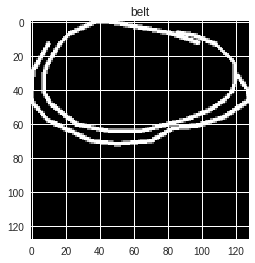

In [0]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    
    model.add(Conv2D(128, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))

    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = 100
EPOCHS = 250 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='top_3_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='top_3_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    ModelCheckpoint("./CNN_2_dropout.model",monitor='top_3_accuracy', mode = 'max', save_best_only=True, verbose=1)
]

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
CNN_2_dropout = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/250
100/100 [==============================] - 43s 427ms/step - loss: 5.4995 - categorical_accuracy: 0.0356 - top_3_accuracy: 0.0730

Epoch 00001: top_3_accuracy improved from -inf to 0.07297, saving model to ./CNN_2_dropout.model
Epoch 2/250
100/100 [==============================] - 41s 411ms/step - loss: 4.8949 - categorical_accuracy: 0.0789 - top_3_accuracy: 0.1592

Epoch 00002: top_3_accuracy improved from 0.07297 to 0.15922, saving model to ./CNN_2_dropout.model
Epoch 3/250
100/100 [==============================] - 41s 410ms/step - loss: 4.5455 - categorical_accuracy: 0.1147 - top_3_accuracy: 0.2284

Epoch 00003: top_3_accuracy improved from 0.15922 to 0.22844, saving model to ./CNN_2_dropout.model
Epoch 4/250
100/100 [==============================] - 41s 410ms/step - loss: 4.2365 - categorical_accuracy: 0.1622 - top_3_accuracy: 0.2992

Epoch 00004: top_3_accuracy improved from 0.22844 to 0.29922, saving model to ./CNN_2_dropout.model
Epoch 5/250
100/100 [==============

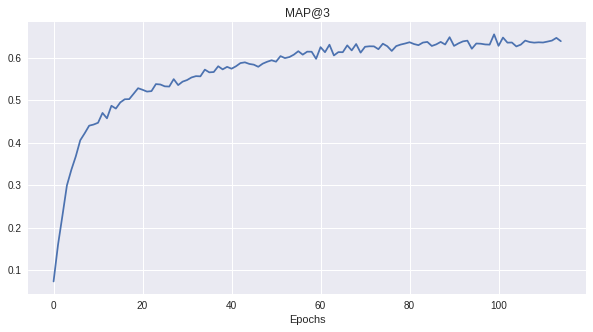

In [0]:
plt.figure(figsize=(10,5))
plt.legend(loc='best')
plt.title('MAP@3')
plt.xlabel('Epochs')
plt.plot(CNN_2_dropout.history['top_3_accuracy'])
plt.show()

**Вывод:** На  тестовых данных  на kaggle выдает 0.574. Результат уже лучше по сравнению с первым экспериментом. Модель переобучается не так сильно




#Эксперимент №3

Построение модели с добавлением DropOut на полносвязном слое, чтобы избежать переобучения. Сильно увеличила batch_size, чтобы установить влияет ли он на переобучение

In [0]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

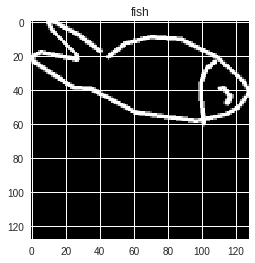

In [0]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

In [0]:
 def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    
    model.add(Conv2D(32, (3,3),padding='same', activation='elu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    
    model.add(Conv2D(64, (3,3),padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation='elu'))
    model.add(Dropout(0.25))
  
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [146]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16777472  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 250 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='top_3_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='top_3_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    ModelCheckpoint("./CNN_3_dropout.model",monitor='top_3_accuracy', mode = 'max', save_best_only=True, verbose=1)
]

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
CNN_3_dropout = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/250
100/100 [==============================] - 55s 548ms/step - loss: 4.6047 - categorical_accuracy: 0.1294 - top_3_accuracy: 0.2335

Epoch 00001: top_3_accuracy improved from -inf to 0.23348, saving model to ./CNN_3_dropout.model
Epoch 2/250
100/100 [==============================] - 54s 540ms/step - loss: 3.6135 - categorical_accuracy: 0.2605 - top_3_accuracy: 0.4238

Epoch 00002: top_3_accuracy improved from 0.23348 to 0.42377, saving model to ./CNN_3_dropout.model
Epoch 3/250
100/100 [==============================] - 54s 540ms/step - loss: 3.2490 - categorical_accuracy: 0.3213 - top_3_accuracy: 0.4953

Epoch 00003: top_3_accuracy improved from 0.42377 to 0.49529, saving model to ./CNN_3_dropout.model
Epoch 4/250
100/100 [==============================] - 54s 539ms/step - loss: 3.0486 - categorical_accuracy: 0.3541 - top_3_accuracy: 0.5332

Epoch 00004: top_3_accuracy improved from 0.49529 to 0.53324, saving model to ./CNN_3_dropout.model
Epoch 5/250
100/100 [==============

**Вывод:** Итоговое качество на Kaggle 0.67. Без регуляризации простая CNN работает лучше, хотя скорее всего на повышение качество повлиял именно batch_size

#Эксперимент №4

Так как простая CNN c двумя conv слоями дала хороший реузльтат (почти 0.7 на тестовых данных). В этом эксперименте добавлю еще несколько сверточных слоев для распознавания новых фильтров. 

In [7]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

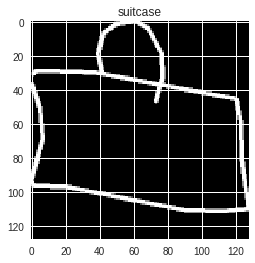

In [13]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [15]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [19]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2)) 

    model.add(Flatten())
    
    model.add(Dense(4098, activation='relu'))
    model.add(Dropout(0.25))
 
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [150]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 250 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='top_3_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='top_3_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    ModelCheckpoint("./CNN_3_dropout.model",monitor='top_3_accuracy', mode = 'max', save_best_only=True, verbose=1)
]

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [46]:
# fit the model with our eternal generator!
CNN_4 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/250
100/100 [==============================] - 41s 413ms/step - loss: 4.6230 - categorical_accuracy: 0.1187 - top_3_accuracy: 0.2156

Epoch 00001: top_3_accuracy improved from -inf to 0.21564, saving model to ./CNN_3_dropout.model
Epoch 2/250
100/100 [==============================] - 36s 356ms/step - loss: 3.0583 - categorical_accuracy: 0.3304 - top_3_accuracy: 0.5207

Epoch 00002: top_3_accuracy improved from 0.21564 to 0.52070, saving model to ./CNN_3_dropout.model
Epoch 3/250
100/100 [==============================] - 36s 356ms/step - loss: 2.6246 - categorical_accuracy: 0.4065 - top_3_accuracy: 0.6072

Epoch 00003: top_3_accuracy improved from 0.52070 to 0.60721, saving model to ./CNN_3_dropout.model
Epoch 4/250
100/100 [==============================] - 36s 356ms/step - loss: 2.3854 - categorical_accuracy: 0.4527 - top_3_accuracy: 0.6540

Epoch 00004: top_3_accuracy improved from 0.60721 to 0.65396, saving model to ./CNN_3_dropout.model
Epoch 5/250
100/100 [==============

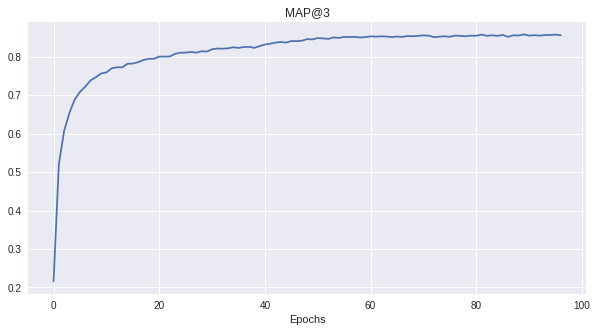

In [65]:
plt.figure(figsize=(10,5))
plt.legend(loc='best')
plt.title('MAP@3')
plt.xlabel('Epochs')
plt.plot(CNN_4.history['top_3_accuracy'])
plt.show()

Удалось получить 0.8 на kaggle  ссылка на скриншот https://drive.google.com/file/d/1WAmjYbXIDr03-qICirBZOjbQbPI0_z9B/view

**Вывод:**  Параметров обучалось меньше, чем на прошлом этапе, но из-за большого количества сверточных слоев, качество значительно улучшилось. 

**Про значения DropOut:** На последнем сверточном слое 0.2, на полносвязном 0.25. Так как на сверточных слоях следует использовать меньше, чтобы не потерять нужные фильтры при выключении нейронов

#Эксперимент №5

Цель проведения экспериментов 5 и 6: установить лучшую фукцию активации для этих данных. В эксперименте 4 удалось получить хорошее качества с активацией **relu**. В эксперименте 5 будет использоваться активация **elu** на той же модели 

In [68]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [74]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [76]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', activation='elu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(4098, activation='elu'))
    model.add(Dropout(0.25))
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [152]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 250 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='top_3_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='top_3_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    ModelCheckpoint("./CNN_3_dropout.model",monitor='top_3_accuracy', mode = 'max', save_best_only=True, verbose=1)
]

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [83]:
# fit the model with our eternal generator!
CNN_4 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/250
100/100 [==============================] - 38s 382ms/step - loss: 4.2604 - categorical_accuracy: 0.1651 - top_3_accuracy: 0.2894

Epoch 00001: top_3_accuracy improved from -inf to 0.28936, saving model to ./CNN_3_dropout.model
Epoch 2/250
100/100 [==============================] - 37s 368ms/step - loss: 3.1689 - categorical_accuracy: 0.3297 - top_3_accuracy: 0.5092

Epoch 00002: top_3_accuracy improved from 0.28936 to 0.50924, saving model to ./CNN_3_dropout.model
Epoch 3/250
100/100 [==============================] - 37s 369ms/step - loss: 2.8889 - categorical_accuracy: 0.3747 - top_3_accuracy: 0.5651

Epoch 00003: top_3_accuracy improved from 0.50924 to 0.56508, saving model to ./CNN_3_dropout.model
Epoch 4/250
100/100 [==============================] - 37s 369ms/step - loss: 2.7296 - categorical_accuracy: 0.4067 - top_3_accuracy: 0.5968

Epoch 00004: top_3_accuracy improved from 0.56508 to 0.59678, saving model to ./CNN_3_dropout.model
Epoch 5/250
100/100 [==============

 LB  = 0.756. 
 
 **Вывод:**  Результаты с активацией elu хуже, чем с активацией relu. Поэтому активацию selu, как мне кажется, использовать не стоит, потому что она похожа на elu. На следующем эксперименте заменю relu на LeakyRelu 

#Эксперимент №6

Та же сеть, что и в эксперименте 4, только с активацией **LeakyReLU**

In [100]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [106]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [108]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
   

    model.add(Dense(4098))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
  
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [115]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 250 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='top_3_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='top_3_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    ModelCheckpoint("./CNN_6.model",monitor='top_3_accuracy', mode = 'max', save_best_only=True, verbose=1)
]

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [120]:
# fit the model with our eternal generator!
CNN_6 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/250
100/100 [==============================] - 47s 473ms/step - loss: 4.4783 - categorical_accuracy: 0.1351 - top_3_accuracy: 0.2447

Epoch 00001: top_3_accuracy improved from -inf to 0.24471, saving model to ./CNN_6.model
Epoch 2/250
100/100 [==============================] - 46s 463ms/step - loss: 2.9743 - categorical_accuracy: 0.3474 - top_3_accuracy: 0.5386

Epoch 00002: top_3_accuracy improved from 0.24471 to 0.53859, saving model to ./CNN_6.model
Epoch 3/250
100/100 [==============================] - 46s 463ms/step - loss: 2.4918 - categorical_accuracy: 0.4344 - top_3_accuracy: 0.6354

Epoch 00003: top_3_accuracy improved from 0.53859 to 0.63539, saving model to ./CNN_6.model
Epoch 4/250
100/100 [==============================] - 46s 462ms/step - loss: 2.2756 - categorical_accuracy: 0.4786 - top_3_accuracy: 0.6760

Epoch 00004: top_3_accuracy improved from 0.63539 to 0.67602, saving model to ./CNN_6.model
Epoch 5/250
100/100 [==============================] - 46s 462ms/st

**Вывод:** LB=0.816 (с активацией relu было LB=0.808). Результат улучшился, но не намного

#Эксперимент №7

Еще одна попытка настроить регуляризацию. Пока удалось получить лучший результат только с использованием регуляризации DropOut. Добавлю после каждого слоя сверточного слоя и на полносвязном **BatchNormalization** 

In [118]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [124]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [126]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
   

    model.add(Dense(4098))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
  
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [128]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
__________

Exception tensorflow.python.framework.errors_impl.CancelledError: CancelledError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f9ec28a5f10>> ignored


In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 100 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='top_3_accuracy', patience=8, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='top_3_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    ModelCheckpoint("./CNN_7.model",monitor='top_3_accuracy', mode = 'max', save_best_only=True, verbose=1)
]

In [0]:
last_finished_epoch = 0


In [133]:
# fit the model with our eternal generator!
CNN_7 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/100
100/100 [==============================] - 68s 676ms/step - loss: 3.9216 - categorical_accuracy: 0.2304 - top_3_accuracy: 0.3785

Epoch 00001: top_3_accuracy improved from -inf to 0.37848, saving model to ./CNN_7.model
Epoch 2/100
100/100 [==============================] - 66s 657ms/step - loss: 2.8939 - categorical_accuracy: 0.3722 - top_3_accuracy: 0.5632

Epoch 00002: top_3_accuracy improved from 0.37848 to 0.56320, saving model to ./CNN_7.model
Epoch 3/100
100/100 [==============================] - 65s 654ms/step - loss: 2.5447 - categorical_accuracy: 0.4344 - top_3_accuracy: 0.6303

Epoch 00003: top_3_accuracy improved from 0.56320 to 0.63027, saving model to ./CNN_7.model
Epoch 4/100
100/100 [==============================] - 65s 653ms/step - loss: 2.3663 - categorical_accuracy: 0.4672 - top_3_accuracy: 0.6629

Epoch 00004: top_3_accuracy improved from 0.63027 to 0.66295, saving model to ./CNN_7.model
Epoch 5/100
100/100 [==============================] - 65s 654ms/st

**Вывод:** На тестовых данных результат немного улучшился, но на kaggle остался такими же. Можно предположить, что BatchNormalization можно не использовать в данном обучении

#Эксперимент №8 Аугментация

Использую лучшую модель CNN с LeakyReLU, только в генератор подаю измененные картинки 

In [125]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

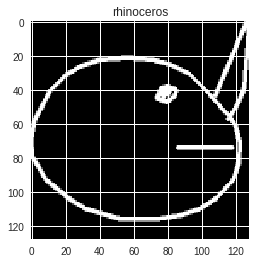

In [131]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

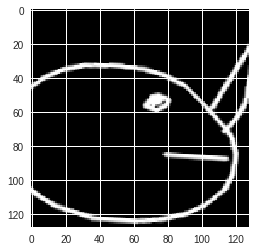

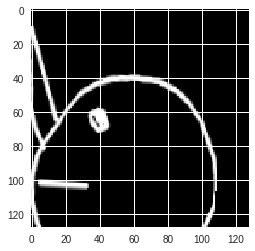

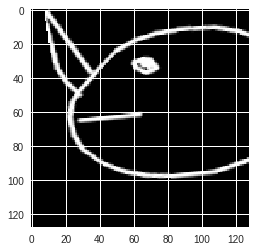

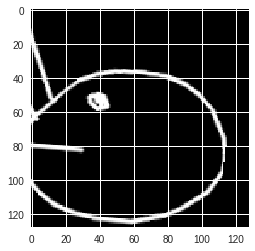

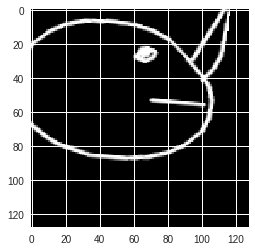

In [132]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=10, #случайная ротация
    width_shift_range=0.2, #случайное отображение горизонтально или вертикально 
    height_shift_range=0.2,
    zoom_range=0.2, #случайное приближение
    horizontal_flip=True, #случайный переворот части изображения 
    fill_mode='constant', #заполнение новых пикселей, полученных в результате сдвигов или отражения 
    cval=255
)

image = b[0][10, :, :]

# add 3 channels to image
image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))

# 5 random augmentations
for _ in range(5):
    plt.imshow(image_gen.random_transform(image)[:, :, 0])
    plt.show()

In [0]:
def images_and_labels_generator_foraug(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        batch_images = image_gen.random_transform(batch_images) #добавляю картинки 
        yield batch_images, batch_labels

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [135]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator_foraug(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [137]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
   

    model.add(Dense(4098))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
  
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [139]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 20 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

In [144]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print GOOGLE_DRIVE_ROOT

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model{}_aug1"
print CHECKPOINT_TEMPLATE

/content/gdrive/My Drive
/content/gdrive/My Drive/model{}_aug1


In [145]:
# fit the model with our eternal generator!
CNN8 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/20
100/100 [==============================] - 96s 962ms/step - loss: 5.8297 - categorical_accuracy: 0.0031 - top_3_accuracy: 0.0091
Model saved in /content/gdrive/My Drive/model0_aug1
Epoch 2/20
100/100 [==============================] - 96s 960ms/step - loss: 5.8294 - categorical_accuracy: 0.0033 - top_3_accuracy: 0.0093
Model saved in /content/gdrive/My Drive/model1_aug1
Epoch 3/20
100/100 [==============================] - 104s 1s/step - loss: 5.8293 - categorical_accuracy: 0.0030 - top_3_accuracy: 0.0095
Model saved in /content/gdrive/My Drive/model2_aug1
Epoch 4/20
100/100 [==============================] - 99s 992ms/step - loss: 5.8294 - categorical_accuracy: 0.0029 - top_3_accuracy: 0.0087
Model saved in /content/gdrive/My Drive/model3_aug1
Epoch 5/20
100/100 [==============================] - 97s 968ms/step - loss: 5.8295 - categorical_accuracy: 0.0031 - top_3_accuracy: 0.0087
Model saved in /content/gdrive/My Drive/model4_aug1
Epoch 6/20
100/100 [======================

**Вывод:** Качество на тестовой выборке очень низкое, возможно аугментация слишком сильная

#Эксперимент №9 Аугментация 

Попробую аугментировать изображения с помощью библиотеки imgaug. Выбираю параметры для минимального измнения картинок: только свдиги, отражение и афинные преобразования

In [146]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

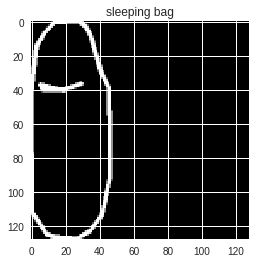

In [151]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

In [153]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 6.3MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
from imgaug import augmenters as iaa
image_gen = iaa.Sequential([
    iaa.Crop(px=(0, 16)),  
    iaa.Fliplr(0.5), 
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        rotate=(-25, 25),
    )
])

In [0]:
def images_and_labels_generator_foraug(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        batch_images = image_gen.augment_images(batch_images) #добавляю картинки 
        yield batch_images, batch_labels

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [163]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator_foraug(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [165]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
   

    model.add(Dense(4098))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
  
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [167]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 20 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

In [172]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print GOOGLE_DRIVE_ROOT

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model{}_aug2"
print CHECKPOINT_TEMPLATE

/content/gdrive/My Drive
/content/gdrive/My Drive/model{}_aug2


In [173]:
# fit the model with our eternal generator!
CNN9 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Exception tensorflow.python.framework.errors_impl.CancelledError: CancelledError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f0d970e4f10>> ignored


Epoch 1/20
100/100 [==============================] - 63s 626ms/step - loss: 5.4472 - categorical_accuracy: 0.0222 - top_3_accuracy: 0.0548
Model saved in /content/gdrive/My Drive/model0_aug2
Epoch 2/20
100/100 [==============================] - 61s 614ms/step - loss: 4.6431 - categorical_accuracy: 0.0942 - top_3_accuracy: 0.1905
Model saved in /content/gdrive/My Drive/model1_aug2
Epoch 3/20
100/100 [==============================] - 61s 611ms/step - loss: 4.0922 - categorical_accuracy: 0.1670 - top_3_accuracy: 0.3009
Model saved in /content/gdrive/My Drive/model2_aug2
Epoch 4/20
100/100 [==============================] - 61s 614ms/step - loss: 3.7280 - categorical_accuracy: 0.2184 - top_3_accuracy: 0.3795
Model saved in /content/gdrive/My Drive/model3_aug2
Epoch 5/20
100/100 [==============================] - 61s 615ms/step - loss: 3.4638 - categorical_accuracy: 0.2590 - top_3_accuracy: 0.4308
Model saved in /content/gdrive/My Drive/model4_aug2
Epoch 6/20
100/100 [====================

Качество уже лучше, LB = 0.618; сравню с обучением на исходных картинках 

#Эксперимернт №10 Без аугментации. Для сравнения

Та же сеть, что и в эксперименте 6, обученная на исходном датасете для сравнения качества. Обучаю всего 20 эпох, так как этого достаточно для того, чтобы определить, что лучше работает

In [181]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [0]:
import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [187]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/ 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [189]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3,3),padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
     
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(128, (3,3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
   

    model.add(Dense(4098))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.25))
  
  
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    
    return model

In [191]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 100
EPOCHS = 20 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

In [196]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print GOOGLE_DRIVE_ROOT

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model{}_withoutaug"
print CHECKPOINT_TEMPLATE

/content/gdrive/My Drive
/content/gdrive/My Drive/model{}_withoutaug


In [197]:
CNN10 = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/20
100/100 [==============================] - 47s 473ms/step - loss: 4.5370 - categorical_accuracy: 0.1285 - top_3_accuracy: 0.2342
Model saved in /content/gdrive/My Drive/model0_withoutaug
Epoch 2/20
100/100 [==============================] - 46s 461ms/step - loss: 3.0334 - categorical_accuracy: 0.3384 - top_3_accuracy: 0.5305
Model saved in /content/gdrive/My Drive/model1_withoutaug
Epoch 3/20
100/100 [==============================] - 46s 461ms/step - loss: 2.5260 - categorical_accuracy: 0.4324 - top_3_accuracy: 0.6292
Model saved in /content/gdrive/My Drive/model2_withoutaug
Epoch 4/20
100/100 [==============================] - 46s 461ms/step - loss: 2.2825 - categorical_accuracy: 0.4758 - top_3_accuracy: 0.6746
Model saved in /content/gdrive/My Drive/model3_withoutaug
Epoch 5/20
100/100 [==============================] - 46s 460ms/step - loss: 2.1210 - categorical_accuracy: 0.5082 - top_3_accuracy: 0.7056
Model saved in /content/gdrive/My Drive/model4_withoutaug
Epoch 6/20

Модель на исходных данных обучается заметно лучше, чем на аугментированных. Даже при 20 эпохах, LB=0.744

#Сравнение качества с аугментацией и без

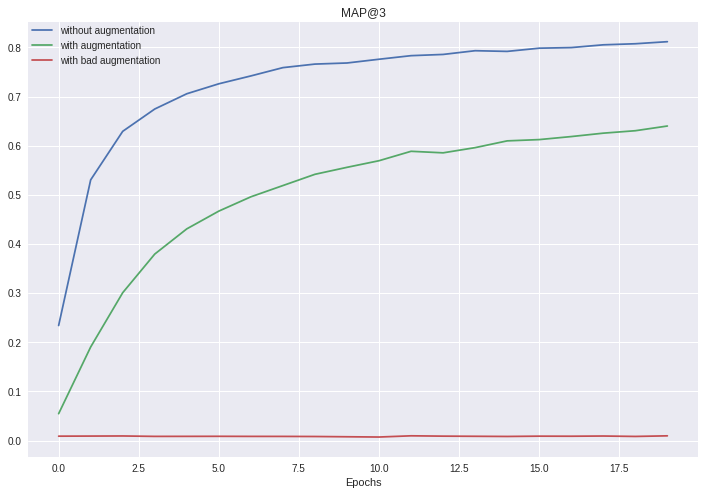

In [228]:
plt.figure(figsize=(12,8))
plt.legend(loc='best')
plt.title('MAP@3')
plt.xlabel('Epochs')
line1 = plt.plot(CNN10.history['top_3_accuracy'], label='without augmentation')
line2 = plt.plot(CNN9.history['top_3_accuracy'],label = 'with augmentation')
line3 = plt.plot(CNN8.history['top_3_accuracy'],label = 'with bad augmentation')
plt.legend(loc=2, borderaxespad=0.)
plt.show()

**Выводы по аугментации:** Даже минимальная аугментация только портит качество как на обучении, так и на тесте. Аугментация в данном случае не нужна, потому что датасет большой и состоит из разных картинок. Возможно аугментация на этом датасете поможет, когда качество будет более 0.9. Использую очень простую аугментацию, потому что картинки простые и маленькие, не надо использовать, например, размытие 

#Выводы и результаты



*   Максимальный скор **LB=0.816**
*   Получилось доказать, что лучшая регуляризация **LeakyReLU**
*   Регуляризация **BatchNormalization** не изменила результат
*   При использовании большого **размера батча** лучше качество
*   **Dropout** убрал переобучение 
*   **EarlyStopping** позволил также избежать переобучения и вовремя останавливал модель, когда переставало расти качество
*   **Аугментация** скорее всего не нужна в данном датасете
*   Поняла, что надо сначала строить максимально простую CNN, а уже потом добавлять регуляризацию и дополнительные слои





# Score test set

In [198]:
# download test set
! KAGGLE_USERNAME=adtsvetkova KAGGLE_KEY=711dab66e0f54e09951120830972f100 kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

test_simplified.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images/ 255 - 0.5
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images/ 255 - 0.5
            yield batch_keys, batch_images

In [200]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [201]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

100%|██████████| 220/220.0 [01:32<00:00,  2.37it/s]


In [202]:
! wc -l submission.csv

112200 submission.csv


In [203]:
# submit to kaggle
! KAGGLE_USERNAME=adtsvetkova KAGGLE_KEY=711dab66e0f54e09951120830972f100 kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.40M/4.40M [00:00<00:00, 15.3MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge